# Classic Hypothesis Testing

 Hypothesis testing is the cornerstone of evidence based decision making. The A/B testing framework is the most used statistical framework for making gradual but important changes in every aspect of today’s business. 


 An A/B test is an experiment where you test two variants, A and B, against each other to evaluate which one performs best in a randomized experiment. The two variants to be tested can be classified as control group, who are shown the current state of of a product or service, and exposed group, who are shown the testing product or service.

 A/B testing involves randomly selecting users and showing one set the control and the other the treatment. The conversion rates for each group is then monitored to determine which one is better. Randomness in A/B testing is key to isolate the impact of the change made and to reduce the potential impact of confounding variables.

**Case Overview**:

SmartAd is a mobile first advertiser agency. 

The company provides an additional service called Brand Impact Optimiser (BIO), a lightweight questionnaire, served with every campaign to determine the impact of the ad they design.

The task at hand is to design a reliable hypothesis testing algorithm for the BIO service and determine whether the recent advertising campaign resulted in a significant lift in brand awareness.

**Data**:

The BIO data for this project is a “Yes” and “No” response of online users to the following question:


`Q: Do you know the brand Lux?`

      Yes
      No

The data has the following columns:
 **auction_id**,  **experiment**, **date**, **hour**, **device_make**, **platform_os**, **browser**, **yes**, **no**.


- **auction_id**: the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.
- **experiment**: which group the user belongs to - control or exposed.
- **date**: the date in YYYY-MM-DD format
- **hour**: the hour of the day in HH format.
- **device_make**: the name of the type of device the user has e.g. Samsung
- **platform_os**: the id of the OS the user has. 
- **browser**: the name of the browser the user uses to see the BIO questionnaire.
- **yes**: 1 if the user chooses the “Yes” radio button for the BIO questionnaire.
- **no**: 1 if the user chooses the “No” radio button for the BIO questionnaire.

In [84]:
# import the required packages and libraries
import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../script')))

import pandas as pd
import numpy as np

import matplotlib as mpl
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
import statsmodels.stats.api as sms
import scipy.stats as scs

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
# pd.set_option('display.float_format', '{:.2f}'.format)

In [85]:
# load the dataset
df = pd.read_csv("../data/AdSmartABdata.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [86]:
# read top 5 rows
df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [87]:
# description of the data
df.describe(exclude=object)

,hour,platform_os,yes,no
count,8077.00,8077.00,8077.00,8077.00
mean,11.62,5.95,0.07,0.08
std,5.73,0.22,0.26,0.28
min,0.00,5.00,0.00,0.00
25%,7.00,6.00,0.00,0.00
50%,13.00,6.00,0.00,0.00
75%,15.00,6.00,0.00,0.00
max,23.00,7.00,1.00,1.00


In [88]:
# description of the data
df.describe(include=object)

,auction_id,experiment,date,device_make,browser
count,8077,8077,8077,8077,8077
unique,8077,2,8,270,15
top,0008ef63-77a7-448b-bd1e-075f42c55e39,control,2020-07-03,Generic Smartphone,Chrome Mobile
freq,1,4071,2015,4743,4554


In [89]:
df['yes'].value_counts()

0    7505
1     572
Name: yes, dtype: int64

In [90]:
pd.crosstab(df['experiment'], df['no'])

no,0,1
experiment,,
control,3749,322
exposed,3657,349


In [91]:
# number of control and exposed groups in the dataset
df['experiment'].value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

In [92]:
# remove those who do not respond at all and add new column "target"
classic_df = df.copy()
classic_df['awared'] = np.where(classic_df['yes'] == 1, 1, 0)
classic_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,awared
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,0


In [93]:
# chekck if there are users that have been populated multiple times.
session_counts = classic_df['auction_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


The principles of Classical A/B testing.

* You define the baseline conversion rate and minimum detectable effect (MDE)
* You calculate the sample size needed for a meaningful experiment using the metrics in step one along with statistical power and significance level
* You drive traffic to your variations until you rech the target sample for each variation
* Finally you evaluate the results of your A/B test. If the difference in performance between variations reached MDE or exceeded it, the hypothesis of your experiment is proven right, otherwise, it's necessary to start the test from scratch.


In [94]:
# additional columns 
classic_df_summary = classic_df.pivot_table(values='awared',index='experiment',aggfunc=np.sum)
classic_df_summary['total'] = classic_df.pivot_table(values='awared',index='experiment',aggfunc=lambda x: len(x))
classic_df_summary['rate'] = classic_df.pivot_table(values='awared',index='experiment')
classic_df_summary

,awared,total,rate
experiment,,,
control,264,4071,0.06
exposed,308,4006,0.08


In [95]:
# define the baseline conversion rate
control_awared = 264
control_total = 4071
control_conversion_rate = 0.06

exposed_awared = 308
exposed_total = 4006
exposed_conversion_rate = 0.08

In [96]:
# calculate the difference rate
exposed_rate = classic_df_summary['rate']['exposed']
control_rate = classic_df_summary['rate']['control']
difference_rate = exposed_rate - control_rate
difference_rate

0.012035741524044075

the two groups have a conversion difference rate of 1.2%.

Text(0, 0.5, 'probability')

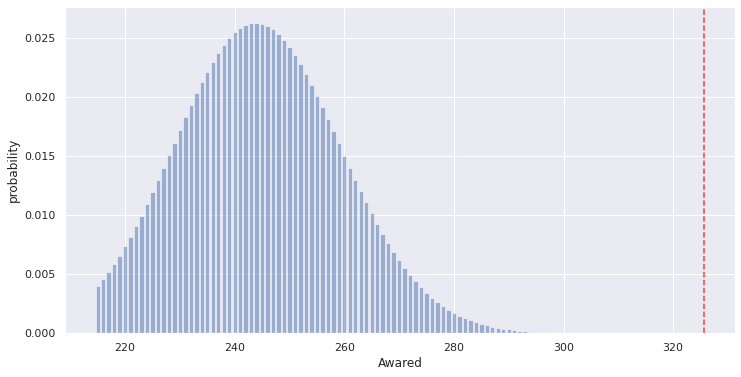

In [98]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(control_awared-49, control_awared+50, 100)
y = scs.binom(control_total, control_conversion_rate).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=exposed_conversion_rate * control_total, c='red', alpha=0.75, linestyle='--')
plt.xlabel('Awared')
plt.ylabel('probability')


The distribution for the control group is shown in blue and the result from the exposed group is indicated by the red dashed line. We can see that the probability of getting the result from the exposed group was very low. However, the probability does not convey the confidence level of the results. It does not take the sample size of our test group into consideration.As a result we do not have an evidence to make a decision.

# Binomial distribution

Text(0, 0.5, 'probability')

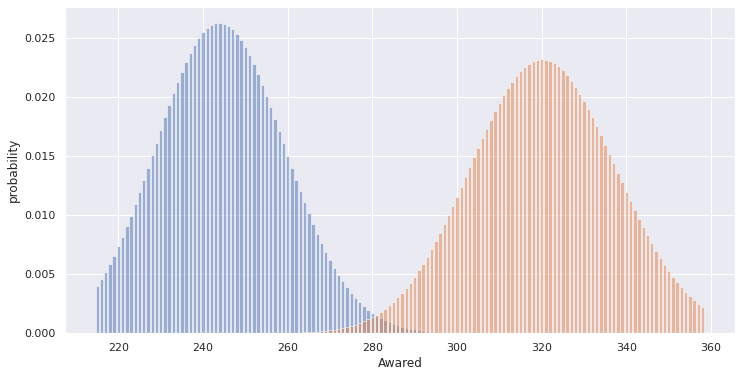

In [99]:
fig, ax = plt.subplots(figsize=(12,6))
xC = np.linspace(control_awared-49, control_awared+50, 100)
yC = scs.binom(control_total, control_conversion_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5)
xE = np.linspace(exposed_awared-49, exposed_awared+50, 100)
yE = scs.binom(exposed_total, exposed_conversion_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5)
plt.xlabel('Awared')
plt.ylabel('probability')